In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import calendar
import quantstats as qs
import scipy.stats as stats

In [2]:
STARTING_DAY = datetime.datetime(1989, 1, 1)
FIRST_ACTION_DAY = datetime.datetime(1994, 1, 1)

In [3]:
ew_weights = pd.read_csv('data/ew_weights.csv', index_col=0)
min_variance_weights = pd.read_csv('data/min_variance_weights.csv', index_col=0)
ew_weights.index = pd.to_datetime(ew_weights.index)
min_variance_weights.index = pd.to_datetime(min_variance_weights.index)

In [4]:
selected_stocks = pd.read_excel('data/selected_stocks.xlsx')

# Download prices
symbols = selected_stocks['Symbol'].tolist()
prices = yf.download(symbols)

# Exclude data before STARTING DAY
prices = prices.loc[STARTING_DAY:]

# Separate variables
adj_close_df = prices['Adj Close']
close_df = prices['Close']
open_df = prices['Open']

adj_close_returns = utils.compute_returns(adj_close_df)
close_returns = utils.compute_returns(close_df)
open_returns = utils.compute_returns(open_df)

[*********************100%%**********************]  11 of 11 completed


In [5]:
action_days = ew_weights.index

# Monthly returns

In [6]:
ew_strategy_monthly_returns = []
min_variance_strategy_monthly_returns = []
for i in range(len(action_days) - 1):
    start = action_days[i]
    end = action_days[i+1] - datetime.timedelta(days=1)  # End is included
    stocks_returns_in_period = adj_close_returns.loc[start:end]
    w_ew = ew_weights.loc[start]
    w_min_var = min_variance_weights.loc[start]
    ew_strategy_monthly_returns.append(
        utils.compute_single_period_cum_returns(stocks_returns_in_period, w_ew).sum(axis=1).iloc[-1] - 1)
    min_variance_strategy_monthly_returns.append(
        utils.compute_single_period_cum_returns(stocks_returns_in_period, w_min_var).sum(axis=1).iloc[-1] - 1)

In [7]:
df_strategy_monthly = pd.DataFrame(
    {
        'ew_strategy': ew_strategy_monthly_returns,
        'min_variance_strategy': min_variance_strategy_monthly_returns
    },
    index=action_days[1:])

In [8]:
month_dict = dict((v, k) for k, v in enumerate(calendar.month_name))
ew_ret_table = pd.DataFrame(df_strategy_monthly.loc[:'2024-01'].iloc[:, 0].values.reshape(-1, 12),
                            index=pd.Series(range(1994, 2024), name='Year'),
                            columns=list(month_dict.keys())[1:])

min_var_ret_table = pd.DataFrame(df_strategy_monthly.loc[:'2024-01'].iloc[:, 1].values.reshape(-1, 12),
                                 index=pd.Series(range(1994, 2024), name='Year'),
                                 columns=list(month_dict.keys())[1:])

In [9]:
# Save tables
ew_ret_table.to_excel('data/ew_monthly_returns.xlsx')
min_var_ret_table.to_excel('data/min_var_monthly_returns.xlsx')

In [10]:
plt.style.use('ggplot')
colors = sns.color_palette('Paired', 4)

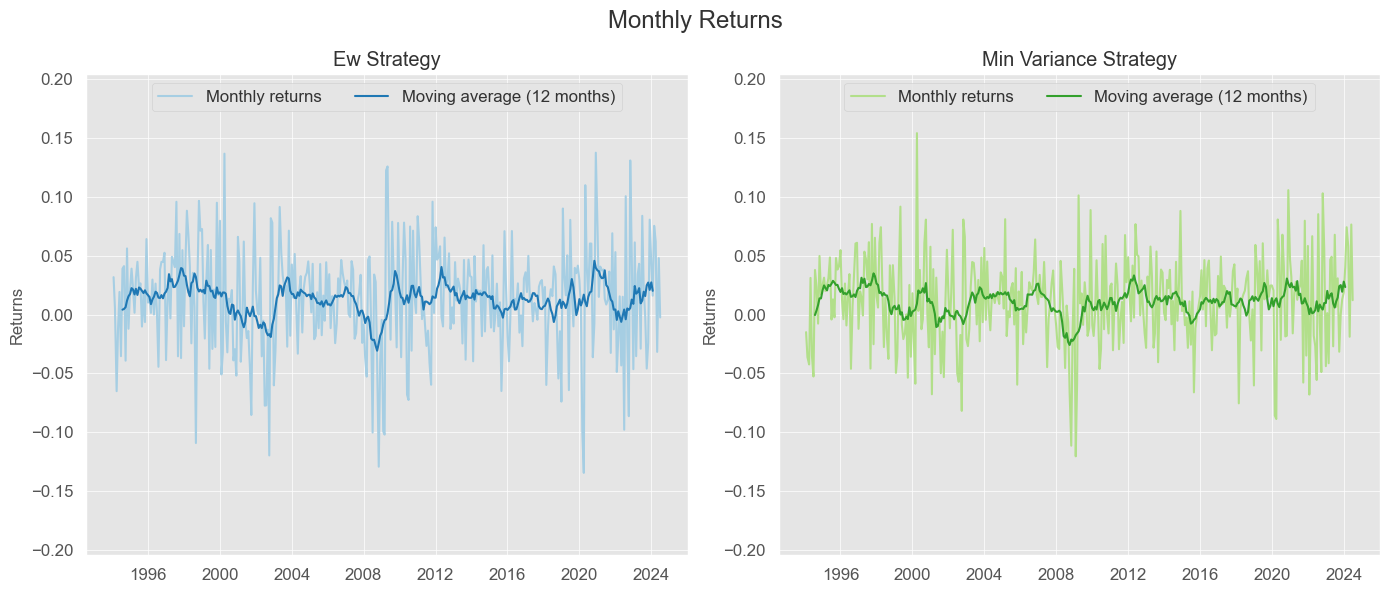

In [11]:
df = df_strategy_monthly

fig1, axes = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)

limit = np.max(np.abs(df.values)).item()
delta = 0.05
rolling_window = 12
for i in range(len(df.columns)):
    # Plot monthly returns
    axes[i].plot(df.iloc[:, i], label=f'Monthly returns', color=colors[i*2])
    # Set same scale
    axes[i].set_ylim((-(limit + delta), limit + delta))
    # Plot moving average
    axes[i].plot(df.iloc[:, i].rolling(rolling_window, center=True).mean(),
                 label=f'Moving average ({rolling_window} months)', color=colors[i*2 + 1])
    axes[i].legend(ncol=2, loc='upper center')
    axes[i].set_title(f'{df.columns[i]}'.replace('_', ' ').title(), fontsize='x-large')
    axes[i].set_ylabel('Returns')
fig1.suptitle(f'Monthly Returns', fontsize='xx-large')
plt.savefig('plots/monthly_returns_ew_vs_min_var.png')
plt.show()

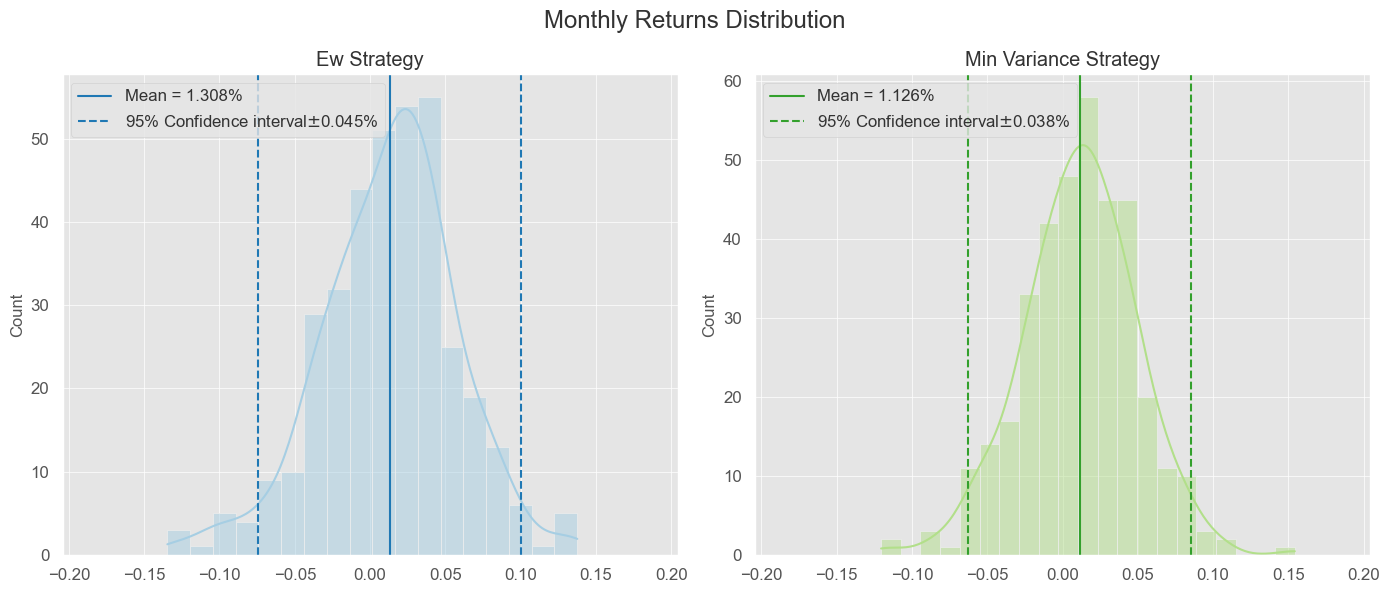

Kurtosis of Ew Strategy: 0.6568289019749809
Skewness of Ew Strategy: -0.290543177159619
Kurtosis of Min Variance Strategy: 0.6610217340871354
Skewness of Min Variance Strategy: -0.1268532738581039


In [12]:
fig2, axes = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
for i in range(len(df.columns)):
    sns.histplot(df.iloc[:, i], ax=axes[i], color=colors[i*2], kde=True)
    axes[i].set_xlim((-(limit + delta), limit + delta))
    axes[i].set_xlabel('')
    axes[i].set_title(f'{df.columns[i]}'.replace('_', ' ').title(), fontsize='x-large')
    mu = df.iloc[:, i].mean()
    sd = df.iloc[:, i].std()
    ci = ((mu - 1.96*sd).item(), (mu + 1.96*sd).item())
    axes[i].axvline(mu, label=f'Mean = {100*mu:.3f}%', color=colors[i*2 + 1])
    axes[i].axvline(ci[0], label=f'95% Confidence interval' + r'$\pm$' + f'{np.round(sd, 3)}%', color=colors[i*2 + 1], ls='--')
    axes[i].axvline(ci[1], color=colors[i*2 + 1], ls='--')

    axes[i].legend()
fig2.suptitle(f'Monthly Returns Distribution', fontsize='xx-large')
plt.savefig('plots/monthly_returns_distribution_ew_vs_min_var.png')
plt.show()
for col in df.columns:
    print(f'Kurtosis of {col.replace("_", " ").title()}: {stats.kurtosis(df[col])}')
    print(f'Skewness of {col.replace("_", " ").title()}: {stats.skew(df[col])}')

# Daily returns

In [16]:
ew_daily_cum_ret = utils.compute_strategy_daily_cum_returns(adj_close_returns, ew_weights).sum(axis=1)
min_var_daily_cum_ret = utils.compute_strategy_daily_cum_returns(adj_close_returns, min_variance_weights).sum(axis=1)

In [29]:
df_strategy_daily = pd.DataFrame(
    {
        'ew_strategy': ew_daily_cum_ret,
        'min_variance_strategy': min_var_daily_cum_ret
    }
)
# Compute returns
df_strategy_daily = utils.compute_returns(df_strategy_daily).iloc[1:]

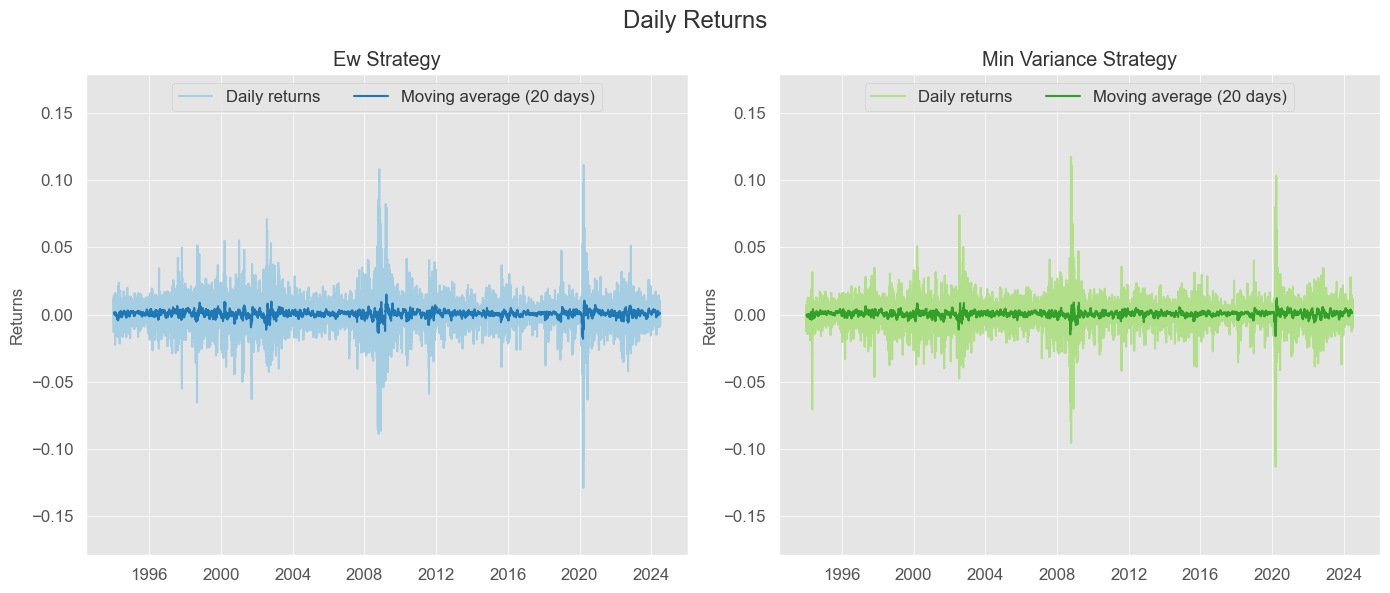

In [27]:
df = df_strategy_daily

fig3, axes = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)

limit = np.max(np.abs(df.values)).item()
delta = 0.05
rolling_window = 20
for i in range(len(df.columns)):
    # Plot monthly returns
    axes[i].plot(df.iloc[:, i], label=f'Daily returns', color=colors[i*2])
    # Set same scale
    axes[i].set_ylim((-(limit + delta), limit + delta))
    # Plot moving average
    axes[i].plot(df.iloc[:, i].rolling(rolling_window, center=True).mean(),
                 label=f'Moving average ({rolling_window} days)', color=colors[i*2 + 1])
    axes[i].legend(ncol=2, loc='upper center')
    axes[i].set_title(f'{df.columns[i]}'.replace('_', ' ').title(), fontsize='x-large')
    axes[i].set_ylabel('Returns')
fig1.suptitle(f'Daily Returns', fontsize='xx-large')
plt.savefig('plots/daily_returns_ew_vs_min_var.png')
plt.show()

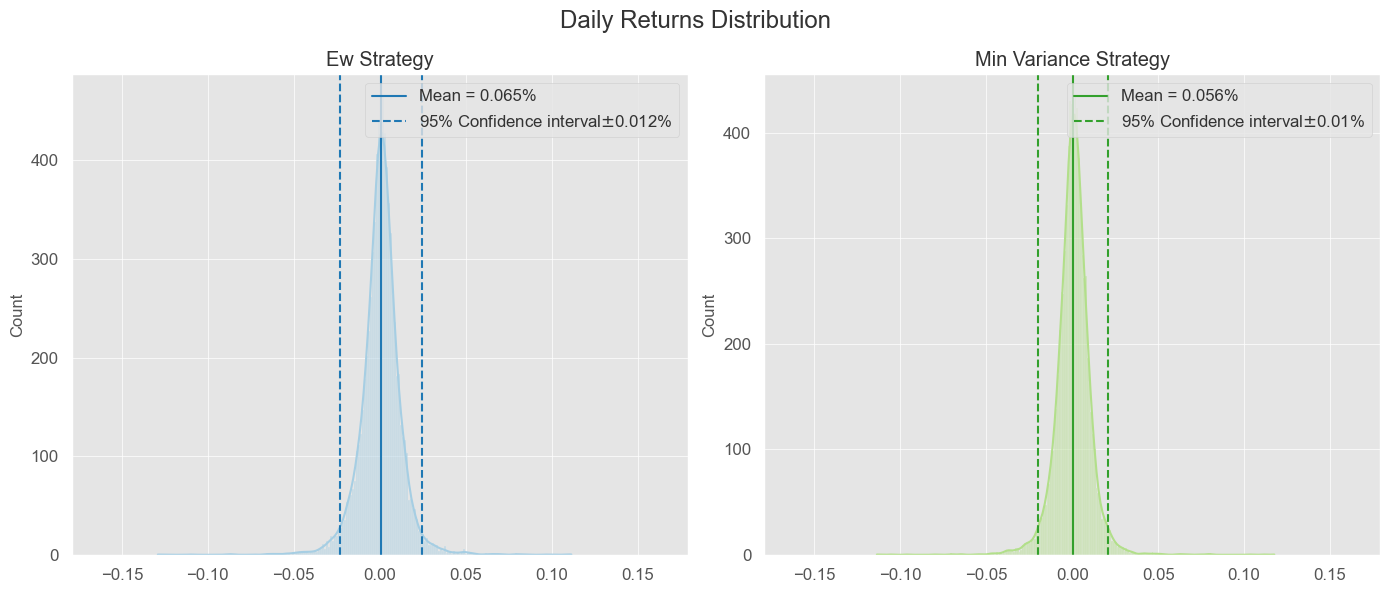

Kurtosis of Ew Strategy: 9.86785201334517
Skewness of Ew Strategy: -0.0799483976403191
Kurtosis of Min Variance Strategy: 14.503583299916901
Skewness of Min Variance Strategy: -0.006251249815456689


In [46]:
fig4, axes = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
for i in range(len(df.columns)):
    sns.histplot(df.iloc[:, i], ax=axes[i], color=colors[i*2], kde=True)
    axes[i].set_xlim((-(limit + delta), limit + delta))
    axes[i].set_xlabel('')
    axes[i].set_title(f'{df.columns[i]}'.replace('_', ' ').title(), fontsize='x-large')
    mu = df.iloc[:, i].mean()
    sd = df.iloc[:, i].std()
    ci = ((mu - 1.96*sd).item(), (mu + 1.96*sd).item())
    axes[i].axvline(mu, label=f'Mean = {100*mu:.3f}%', color=colors[i*2 + 1])
    axes[i].axvline(ci[0], label=f'95% Confidence interval' + r'$\pm$' + f'{np.round(sd, 3)}%', color=colors[i*2 + 1], ls='--')
    axes[i].axvline(ci[1], color=colors[i*2 + 1], ls='--')

    axes[i].legend()
fig4.suptitle(f'Daily Returns Distribution', fontsize='xx-large')
plt.savefig('plots/daily_returns_distribution_ew_vs_min_var.png')
plt.show()
for col in df.columns:
    print(f'Kurtosis of {col.replace("_", " ").title()}: {stats.kurtosis(df[col])}')
    print(f'Skewness of {col.replace("_", " ").title()}: {stats.skew(df[col])}')

In [30]:
help(qs.plots.returns)

Help on function returns in module quantstats._plotting.wrappers:

returns(returns, benchmark=None, grayscale=False, figsize=(10, 6), fontname='Arial', lw=1.5, match_volatility=False, compound=True, cumulative=True, resample=None, ylabel='Cumulative Returns', subtitle=True, savefig=None, show=True, prepare_returns=True)


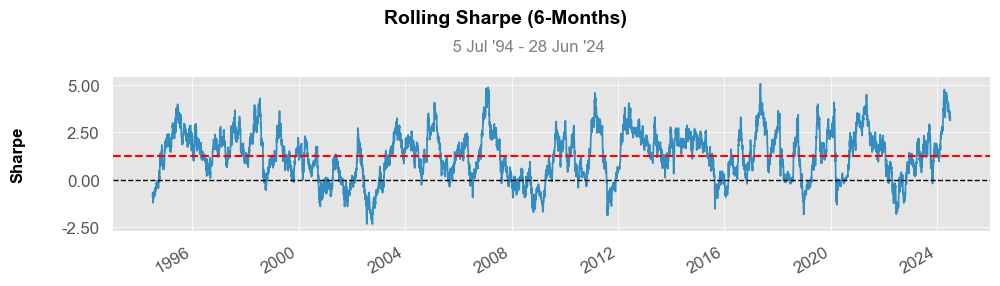

In [45]:

qs.plots.rolling_sharpe(df_strategy_daily.iloc[:, 0])

In [35]:
help(qs.plots.monthly_heatmap)

Help on function monthly_heatmap in module quantstats._plotting.wrappers:

monthly_heatmap(returns, benchmark=None, annot_size=10, figsize=(10, 5), cbar=True, square=False, returns_label='Strategy', compounded=True, eoy=False, grayscale=False, fontname='Arial', ylabel=True, savefig=None, show=True, active=False)
